In [1]:
import torch
torch.cuda.get_device_name(0)

'GeForce RTX 2070 SUPER'

In [2]:
#!pip install opencv-python torch torchvision pandas matplotlib scikit-learn imblearn albumentations
from utils import *
from clr import OneCycle
from radam import RAdam
from opts import *
#shutil.move('/content/ValidationLabels.csv','/content/drive/My Drive/ValidationLabels.csv')
#shutil.make_archive('/content/Labels','zip','/content/DAiSEE')

In [3]:
import pandas as pd
train_label = pd.read_csv(train_label_path)
valid_label = pd.read_csv(valid_label_path)
test_label = pd.read_csv(test_label_path)
train_id,train_classes = create_label(train_label,'./Daisee/Train',change =False) 
test_id,test_classes = create_label(test_label,'./Daisee/Test',change = False) 
valid_id,valid_classes = create_label(valid_label,'./Daisee/Validation',change = False) 

In [4]:
def extract_label(id,classes):
    id_new0 = []
    id_new1 = []
    for i,j in enumerate(classes):
        if(j == 0):
            id_new0.append(id[i])
        if(j == 1):
            id_new1.append(id[i])
    return id_new0,id_new1
train_id = train_id+test_id
train_classes = train_classes+test_classes
train_id0,train_id1 = extract_label(train_id,train_classes)
import numpy as np
#train_id = train_id + 75*train_id0 + 10*train_id1
#train_classes = train_classes + np.zeros(len(75*train_id0),dtype = int).tolist() + np.ones(len(10*train_id1) , dtype = int).tolist()

In [5]:
from collections import Counter
import numpy as np
import torch
np.random.seed(42)
torch.manual_seed(42)
print(Counter(train_classes).keys()) # equals to list(set(words))
print('Train:',np.asarray(list(Counter(train_classes).values())))
print('test:',np.asarray(list(Counter(valid_classes).values())))

dict_keys([2, 3, 1, 0])
Train: [3499 3308 3267 2888]
test: [813 450 143  23]


In [6]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
from PIL import Image
import numpy as np
import cv2
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])
class video_dataset(Dataset):
    def __init__(self,id,label,sequence_length = 60,transform = None,transform1 = None,revert = True):
        self.id =id
        self.engagement = label
        self.transform = transform
        self.transform1 = transform1
        self.count = sequence_length
        self.revert = revert
    def __len__(self):
        return len(self.id)
    def __getitem__(self,idx):
        video_path = self.id[idx]
        frames = []
        cap = cv2.VideoCapture(video_path)
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        a = int(length/self.count)
        hp = np.random.randint(0,2)
        id1 = np.random.randint(0,a)
        label = self.engagement[idx]
        frames = []
        for i,frame in enumerate(frame_extract(video_path)):
            if(i % a == id1):
                #if(label<2):
                #    if(hp == 1):
                #        frame = cv2.flip(frame,1)
                if(self.transform1):
                    frames.append(frame)
                else:
                    frames.append(self.transform(frame))
        if(self.transform1):
            frames = augment_and_mix(frames,transform = self.transform)
        if(self.revert):
          hp = np.random.randint(0,2)
          if(hp == 1):
            frames = frames[::-1]
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames,label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


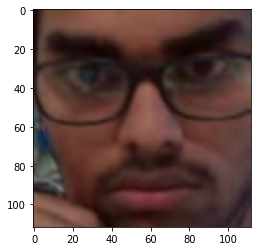

2


In [7]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
import cv2
from albumentations import (
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose,Resize,ImageCompression,MultiplicativeNoise,ChannelDropout,IAASuperpixels,GaussianBlur
)

augs = [
            RandomBrightnessContrast(brightness_limit=0.05,contrast_limit=0.05,p=1),
            Blur(blur_limit=2,p=1),
#            OpticalDistortion(p=1),
            ImageCompression(p=1),
            MultiplicativeNoise(p=1),
#              IAASharpen(alpha=(0, 0.2) , p = 1),
#             IAAEmboss(alpha=(0, 0.3) , p = 1),
            MotionBlur(blur_limit = 3,p=1),
#             MedianBlur(blur_limit=3,p=1)
        ]

def apply_op(frames, op):
    a = op(image = frames)['image']
    return a
import random
def augment_and_mix(image, augs = augs , width = 1, depth = 2, alpha = 1.,transform = None):
    frames = []
    ops = []
    ws = np.float32(np.random.dirichlet([alpha] * width))
    m = np.float32(np.random.beta(alpha, alpha))
    for i in range(width):
        op = []
        ag = augs.copy()
        for j in range(depth):
            a = np.random.choice(ag)
            ag.remove(a)
            op.append(a)
        ops.append(Compose(op))
    for frame in image:
        mix = torch.zeros((3,im_size,im_size))
        for i in range(width):
            image_aug = frame.copy()
            op = ops[i]
            image_aug = transform(apply_op(image_aug, op))
            mix += ws[i] * image_aug
        frames.append((1 - m) * transform(frame) + m * mix)
#        frames.append(mix)
    return frames
im_size = 112
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
train_data = video_dataset(train_id,train_classes,sequence_length = 100,transform = train_transforms,transform1 = False,revert = False)
val_data = video_dataset(valid_id,valid_classes,sequence_length = 100,transform = train_transforms)
#val_data = video_dataset(test_id,test_classes,sequence_length = 100,transform = train_transforms)
import cv2
import random
image,label = train_data[900]
im_plot(image[0,:,:,:])
print(label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
--- 0.1106107234954834 seconds ---
2


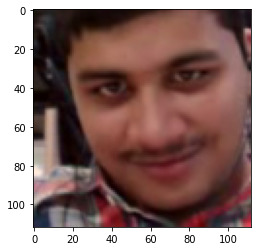

In [8]:
import cv2
import random
import time
start_time = time.time()
image,label = train_data[300]
print("--- %s seconds ---" % (time.time() - start_time))
print(label)
im_plot(image[60,:,:,:])

In [9]:
#!git clone https://github.com/ndrplz/ConvLSTM_pytorch
size = 4
from torchvision import models
import torch
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self,lamb_m = 0.5):
        super(Model, self).__init__()
        model = models.resnet18(pretrained = True)
        model1 = nn.Sequential(*list(model.children())[:-2])
        self.model1 = model1
        self.lstm = nn.LSTM(512, 512, 3, batch_first=True, bidirectional = False)
        self.f1 = nn.Linear(512,4)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.dp1 = nn.Dropout(0.4)
        self.sig = nn.Sigmoid()
        self.pool1 = nn.AdaptiveAvgPool2d(output_size = 1)
        self.attention1 = nn.Linear(512,1)    
        self.lamb_m = lamb_m
    def forward(self, input):
        seq_size = input.shape[1]
        input = input.view(-1,3,im_size,im_size)
        x = self.model1(input)
        x_pool = self.relu(self.pool1(x)).reshape(-1,seq_size,512)
        x_lstm,_ = self.lstm(x_pool)
        x2 = []
        for i in range(x_pool.shape[0]):
            alpha = self.sig(self.attention1(self.dp1(x_pool[i])))
            x2.append(torch.div(torch.sum(x_pool[i]*alpha.reshape(-1,1),dim = 0),torch.sum(alpha,dim = 0)))
        lstm = torch.mean(x_lstm,dim = 1)
        attention = torch.stack(x2)
        x = self.lamb_m*attention+(1-self.lamb_m)*lstm
        x = self.dp(self.f1(x))
        return x
model = Model().to('cuda')

In [10]:
from torch import nn
import numpy as np
soft = nn.Softmax()
soft(model(torch.from_numpy(np.zeros((1,100,3,im_size,im_size))).type(torch.cuda.FloatTensor)))

tensor([[0.2619, 0.3031, 0.2375, 0.1975]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [11]:
#!rm -r results1
!mkdir results2
arch = 'resnet18-lstm+attention-0.5-(75)-10-4-2-1-0.4'#.format(split_no)
result_path = os.path.join('./results2',arch)
from tensorboardX import SummaryWriter
writer = SummaryWriter()
os.makedirs(result_path,exist_ok = True)
train_logger = Logger(os.path.join(result_path, 'train1{}.log'.format(arch)),['epoch', 'loss', 'acc', 'lr'])
train_batch_logger = Logger(
            os.path.join(result_path, 'train_batch1{}.log'.format(arch)),
            ['epoch', 'batch', 'iter', 'loss', 'acc', 'lr'])    
val_logger = Logger(
            os.path.join(result_path, 'val1{}.log'.format(arch)), ['epoch', 'loss', 'acc'])

mkdir: cannot create directory ‘results2’: File exists


In [14]:
import torch
from torch import nn
import numpy as np
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])
class sanchitLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.sig = nn.Tanh()
        self.soft = torch.log
    def forward(self, pred, true):
        clases = torch.arange(0,pred.shape[1],1).reshape(1,-1).repeat(pred.shape[0],1)
        #if(torch.cuda.is_available()):
        #    clases = clases.cuda()
        clases = (abs(clases-true.reshape(-1,1))).type(torch.DoubleTensor)
        dis = clases
        for d in dis:
            if(d[1] == 0):
                d[2] += 1
                continue
            if(d[2] == 0):
                d[1] += 1
                continue
#        dis = dis/torch.sum(dis)
        print(dis)
        #if(torch.cuda.is_available()):
        #    pred = -1*self.soft(pred+1e-10).type(torch.DoubleTensor)
        print(pred)
        loss = torch.sum(dis * pred,axis = 1).type(torch.FloatTensor)
        #sorted, indices = torch.sort(loss)
        return torch.mean(loss,axis = 0)
#        return torch.mean(sorted[int(0.2*len(sorted)):],axis = 0)
s = sanchitLoss()
s(torch.from_numpy(np.asarray([0.1,  0.7,  0.1,  0.1])).unsqueeze(dim = 0).type(torch.FloatTensor),torch.from_numpy(np.asarray([1])).type(torch.LongTensor))

tensor([[1., 0., 2., 2.]], dtype=torch.float64)
tensor([[0.1000, 0.7000, 0.1000, 0.1000]])


tensor(0.5000)

In [13]:
## MSE loss pipeline
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
#sa = SoftArgmax1D()
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer, epoch_logger, batch_logger, batch_size , onecyc , writer , result_path , lamb_l = 0.5):
    print('Training Epoch {}'.format(epoch))
    model.train()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    accuracies = AverageMeter()
    start_time = time.time()
    end_time = time.time()
    t = []
    los = nn.CrossEntropyLoss().cuda()
    for i, (inputs, targets) in enumerate(data_loader):
        data_time.update(time.time() - end_time)
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        outputs = model(inputs)    
        loss1 = criterion(outputs, targets.type(torch.cuda.LongTensor))
        loss  = los(outputs,targets.type(torch.cuda.LongTensor))
        loss = loss*lamb_l +  (1-lamb_l)*loss1
        lr,mom = onecyc.calc()
        update_lr(optimizer, lr)
        update_mom(optimizer,mom)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_time.update(time.time() - end_time)
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))

        batch_logger.log({
            'epoch': epoch,
            'batch': i + 1,
            'iter': (epoch - 1) * len(data_loader) + (i + 1),
            'loss': losses.val,
            'acc': accuracies.val,
            'lr': optimizer.param_groups[0]['lr']
        })
        wandb.log({'Batch accuracy': accuracies.val,'batch Loss':losses.val,'lr': optimizer.param_groups[0]['lr']})
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Time %.2f %.2f] [Data %.2f %.2f] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    batch_time.val,
                    batch_time.avg,
                    data_time.val,
                    data_time.avg,
                    losses.avg,
                    accuracies.avg))
        end_time = time.time()
        
    print('\nEpoch time {} mins'.format((end_time-start_time)/60))
    epoch_logger.log({
        'epoch': epoch,
        'loss': losses.avg,
        'acc': accuracies.avg,
        'lr': optimizer.param_groups[0]['lr']
    })
        
    save_file_path = os.path.join(result_path,'save.pth')
    states = {
        'state_dict': model.state_dict(),
        'optim_dict':optimizer.state_dict()
    }
    wandb.log({'Epoch accuracy': accuracies.avg,'Epoch Loss':losses.avg})
    torch.save(states, save_file_path)
    return t
def test(epoch,model, data_loader ,criterion, batch_size, result_path,best_acc = 0 , logger = None ):
    print('Testing')
    if(epoch == 1):
        best_acc = 0
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    los = nn.CrossEntropyLoss()
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            outputs = model(inputs)
            loss = torch.mean(los(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1)
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        if(logger):
            logger.log({'epoch': epoch, 'loss': losses.avg, 'acc': accuracies.avg})
        print('\nAccuracy {}'.format(accuracies.avg))
        if(accuracies.avg>best_acc):
            best_acc = accuracies.avg
            result_path = os.path.join(result_path,'best.pth')
            state = {
            'acc':best_acc,
             'state':model.state_dict()
            }
            torch.save(state,result_path)
    wandb.log({'Validation accuracy': accuracies.avg,'Validation Loss':losses.avg})
    wandb.log({'true':np.asarray(true),'pred':np.asarray(pred)})
    return true,pred,best_acc

In [14]:
def set_lr(optimizer,lr):
  for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [15]:
import wandb
params = {
          'batch_size': 16,
          'pretrain': True,
          'optimizer' : 'sgd',
          'model' : 'resnet18',
          'loss_lambda': 0,
          'attention_lambda': 0,
          'augmix': False,
          'augmentation_out': 'mix',
          'oversample_0': 0,
          'oversample_1': 0,
          'one_cycle': True,
          'weight_decay': 1e-3,
          'num_lstm_layer': 3,
          'revert': False    
          }
wandb.init(name = 'l{}_a{}_oversample_aug'.format(params['loss_lambda'],params['attention_lambda']),project="daisee",config = params)
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from radam import RAdam
model = Model(lamb_m = 0).to('cuda')
lr = 1e-3
batch_size = 8
train_loader = DataLoader(train_data,batch_size = batch_size , num_workers = 4,shuffle = True,pin_memory = True,drop_last = True)
val_loader = DataLoader(val_data,batch_size = 1, num_workers = 0,pin_memory = True,drop_last = False)
criterion = sanchitLoss().cuda()
best_acc = 0
num_epochs = 15
optimizer = torch.optim.SGD(model.parameters(), lr= lr,weight_decay = 1e-3,momentum = 0.9)
onecyc = OneCycle(len(train_loader)*num_epochs, lr)
wandb.watch(model, log="all")
for epoch in range(1,num_epochs+1):
    train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer,train_logger,train_batch_logger,batch_size,onecyc,writer,result_path,lamb_l = 0)
    true,pred,best_acc= test(epoch,model,val_loader,criterion,batch_size,result_path,best_acc)
    cm1 = confusion_matrix(true,pred)
    print('modified_accuracy:',(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1]+cm1[2,2]+cm1[2,3]+cm1[3,2]+cm1[3,3])/np.sum(cm1))
    print('Comb\n',cm1)
    print(classification_report_imbalanced(true, pred))

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
Training Epoch 1
[Epoch 1/15] [Batch 1619 / 1620] [Time 0.46 0.47] [Data 0.32 0.32] [Loss: 1.083634, Acc: 43.42%]
Epoch time 12.813952390352885 mins
Testing
[Batch 1428 / 1429]  [Loss: 1.003342, Acc: 55.42%]
Accuracy 55.423372988103566
wandb: ERROR Storing tensors in summary requires h5py
wandb: ERROR Storing tensors in summary requires h5py
modified_accuracy: 0.8299510146955913
Comb
 [[  0  11   8   4]
 [  1  76  51  15]
 [  0 124 588 101]
 [  1  40 281 128]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.00      0.00      1.00      0.00      0.00      0.00        23
          1       0.30      0.53      0.86      0.39      0.68      0.44       143
          2       0.63      0.72      0.45      0.68      0.57      0.33       813
          3       0.52      0.28      0.88      0.37      0.50      0.23       450

avg / tot